In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as st
import seaborn as sb
from astropy import constants as const
import random
import astropy.constants as const
import math
from tqdm import tqdm
import extinction as ex
import pdb
import glob
import scipy.optimize as optimization

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
#import statements from Connor's code, I may not make use of all of them

from astropy.io import ascii, fits
import pickle 
from astropy.table import Table, Column, join, hstack
from tqdm import tqdm
import pdb
import scipy.interpolate as sinterp

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
#define function used to fit line to data
def slopeintfunc(x,s1,incpt):
    return s1*x+incpt

In [5]:
# Spectral Type to Temperature Using Herczeg-Hillenbrand

In [6]:
# To decode the numerical spectral types to actual types:
# SpectralClass   Value   Prefix
# B   0-9 0
# A   10-19   1
# F   20-29   2
# G   30-39   3
# K   40-48   4
# M   50-59   5

In [7]:
def to_SpTyNum(spectype):
    spty_dict = {'B' : 0,
                 'A' : 1,
                 'F' : 2,
                 'G' : 3,
                 'K' : 4,
                 'M' : 5}
    
    letter = spectype[0]
    number = spectype[1:]
    
    sptynum = spty_dict[letter]*10 + int(number)
    
    return sptynum

In [27]:
to_SpTyNum('M5')

55

In [14]:
def SpTy_to_Teff(spectype):
    '''
    This function will take a numerical spectral type identifier, and using interpolation from the tables in
    Herczeg and Hillenbrand 2014 it will calculate an effective temperature.
    '''
    SpTyNum, Teff, SpTy = np.genfromtxt('StellarParams/HerczegHillenbrand_SpTyTeff_Numericized.txt', skip_header=1, dtype='str').T
    SpTyNum, Teff = [float(x) for x in SpTyNum], [float(y) for y in Teff]
    
    spl = sinterp.interp1d(SpTyNum, Teff, fill_value='extrapolate')
    
    teff = spl(spectype)
    
    return teff

In [25]:
SpTy_to_Teff(65)
#How are we going to treat BDs here, the temps start increasing after type M unfortunately

array(1970.)

In [16]:
len(SpTyNum)

NameError: name 'SpTyNum' is not defined

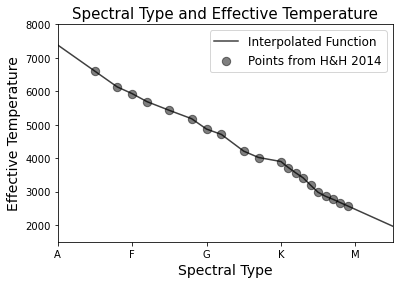

In [59]:
SpTyNum, Teff, SpTy = np.genfromtxt('StellarParams/HerczegHillenbrand_SpTyTeff_Numericized.txt', skip_header=1, dtype='str').T
SpTyNum, Teff = [float(x) for x in SpTyNum], [float(y) for y in Teff]

#spl = sinterp.UnivariateSpline(SpTyNum, Teff)
spl = sinterp.interp1d(SpTyNum, Teff, fill_value='extrapolate')

best = optimization.curve_fit(slopeintfunc, SpTyNum, Teff)
bestslope = str(round(best[0][0], 2))
#plt.plot(range(70), slopeintfunc(range(70), best[0][0], best[0][1]), linestyle='-', color = "salmon", label='Total Best Fit: Slope ='+bestslope)

best1 = optimization.curve_fit(slopeintfunc, SpTyNum[10:], Teff[10:])
best1slope = str(round(best1[0][0], 2))
#plt.plot(range(70), slopeintfunc(range(70), best1[0][0], best1[0][1]), linestyle='-', color = "green", label='M Dwarf Best Fit: Slope ='+best1slope)

plt.plot(range(70), spl(range(70)), label='Interpolated Function', color='k', alpha=0.75)
plt.scatter(SpTyNum, Teff, alpha=0.5, color='k', s=70, label='Points from H&H 2014')
plt.xlabel('Spectral Type', fontsize=14)
plt.ylabel('Effective Temperature', fontsize=14)
#plt.xlim(20, 70)
#plt.ylim(0, 10000)
plt.title('Spectral Type and Effective Temperature', fontsize=15)
plt.legend(fontsize=12)
plt.xlim(25, 65)
plt.xticks([20,30,40,50,60], ['A','F','G','K','M'])
plt.ylim(1500, 8000)
plt.savefig('H&H.png', dpi=120)

In [30]:
# Now from Teff to mass and radius

In [31]:
models = glob.glob('StellarParams/Baraffe*txt')
mesamodels = glob.glob('StellarParams/MESA_*.txt')

models
# 2015 Baraffe models are accurate for all objects w/ Teff < 4658 K
# I will only incorporate Baraffe models at first

['StellarParams/Baraffe2015_10Myr.txt',
 'StellarParams/Baraffe2015_1Myr.txt',
 'StellarParams/Baraffe2015_2Myr.txt',
 'StellarParams/Baraffe2015_3Myr.txt',
 'StellarParams/Baraffe2015_8Myr.txt']

In [32]:
def Teff_to_params(Teff, age):
    '''
    This function will take an effective temperature and an age, and by interpolating the Baraffe 2015 models 
    it will return a mass and radius estimate for the object.
    '''
    #Find the most accurate model given age
    ages = [1, 2, 3, 8, 10]
    age_diff = []
    for a in ages:
        age_diff.append(np.abs(age-a))
    closest_age = ages[age_diff.index(min(age_diff))]
    
    model = None
    for m in models:
        if (str(closest_age)+'Myr') in m:
            model = m
            
    mass, teff, loglum, logg, radius = np.loadtxt(model, skiprows=1).T
    
    p_mass = np.polyfit(teff, mass, 10)
    f_mass = np.poly1d(p_mass)
    
    p_radius = np.polyfit(teff, radius, 10)
    f_radius = np.poly1d(p_radius)
    
    m = f_mass(Teff)
    r = f_radius(Teff)
    
    return m, r

In [33]:
Teff_to_params(3450, 5.4)

(0.32619683706434444, 1.0848985157499555)

In [34]:
# Let's see how much a half spec type error affects mass and radius estimate with MC

In [35]:
spty = 'M5'
sptynum = to_SpTyNum(spty)
spty_unc = 0.5
t_unc = 100
numMC = 500

In [36]:
st = sptynum + np.random.normal(scale = spty_unc, size = numMC)
T = SpTy_to_Teff(st) + np.random.normal(scale = t_unc, size = numMC)
M = Teff_to_params(T, 1)[0]
R = Teff_to_params(T, 1)[1]

In [37]:
Teff_to_params(SpTy_to_Teff(sptynum), 1)

(0.10749615717077177, 1.0713005334255286)

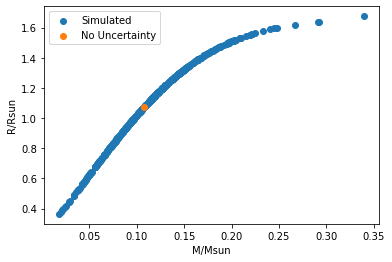

In [38]:
plt.scatter(M, R, label='Simulated')
plt.scatter(0.10749615717077177, 1.0713005334255286, label='No Uncertainty')
plt.xlabel('M/Msun')
plt.ylabel('R/Rsun')
plt.legend()

In [47]:
def mass_to_Teff(massobj, age):
    '''
    This function will take a mass and an age, and by interpolating the Baraffe 2015 models 
    it will return a temperature estimate for the object.
    '''
    #Find the most accurate model given age
    ages = [1, 2, 3, 8, 10]
    age_diff = []
    for a in ages:
        age_diff.append(np.abs(age-a))
    closest_age = ages[age_diff.index(min(age_diff))]
    
    model = None
    for m in models:
        if (str(closest_age)+'Myr') in m:
            model = m
            
    mass, teff, loglum, logg, radius = np.loadtxt(model, skiprows=1).T
    
    p_teff = np.polyfit(mass, teff, 10)
    f_teff = np.poly1d(p_teff)
    
    t = f_teff(massobj)
    
    return t

In [63]:
def Teff_to_SpTy(teff):
    '''
    This function will take an effective temperature, and using interpolation from the tables in
    Herczeg and Hillenbrand 2014 it will calculate a numerical spectral type identifier.
    '''
    SpTyNum, Teff, SpTy = np.genfromtxt('StellarParams/HerczegHillenbrand_SpTyTeff_Numericized.txt', skip_header=1, dtype='str').T
    SpTyNum, Teff = [float(x) for x in SpTyNum], [float(y) for y in Teff]
    SpTyNum.reverse()
    Teff.reverse()
    
    spl = sinterp.UnivariateSpline(Teff, SpTyNum)
    
    spty = spl(teff)
    
    return spty

array(55.7016915)

In [59]:
Teff

[2570.0,
 2670.0,
 2770.0,
 2860.0,
 2980.0,
 3190.0,
 3410.0,
 3560.0,
 3720.0,
 3900.0,
 4020.0,
 4210.0,
 4710.0,
 4870.0,
 5180.0,
 5430.0,
 5690.0,
 5930.0,
 6130.0,
 6600.0]

In [61]:
SpTyNum.reverse()

In [62]:
SpTyNum

[59.0,
 58.0,
 57.0,
 56.0,
 55.0,
 54.0,
 53.0,
 52.0,
 51.0,
 50.0,
 47.0,
 45.0,
 42.0,
 40.0,
 38.0,
 35.0,
 32.0,
 30.0,
 28.0,
 25.0]